In [91]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

In [47]:
fps = sorted(list(Path('/Users/rdcrlzh1/Documents/arctic-radarsat2/Utqiagvik/SLA11').rglob('*.cor.geo')))

In [96]:
import contextlib

def parse_par(par_fp):
    with open(par_fp, 'r') as f:
        lns = f.readlines()
    par = {l.split()[0].strip(':'):l.split()[1] for l in lns if len(l) > 2}

    for k, v in par.items():
        try: par[k] = float(v)
        except: par[k] = v
    return par

def get_width(par):
    cols = [k for k in par.keys() if ('range_samp' in k) or ('width' in k)]
    width = par[cols[0]]
    return width

def gamma_to_numpy(fp, par_fp):
    par = parse_par(par_fp)
    width = get_width(par)
    arr = np.fromfile(fp, '>f4').reshape(-1, int(width))

    return arr, par

def gamma_to_xarray(fp, par_fp):
    arr, par = gamma_to_numpy(fp, par_fp)
    dx, dy = par['post_lon'], par['post_lat']
    xs = np.linspace(par['corner_lon'], par['corner_lon'] + dx* arr.shape[1], arr.shape[1])
    ys = np.linspace(par['corner_lat'], par['corner_lat'] + dy* arr.shape[0], arr.shape[0])
    da = xr.DataArray(arr, dims = {'x', 'y'}, coords = {'y': ys, 'x': xs})
    return da.where((da > 0) & (da < 1)).dropna('x', how = 'all').dropna('y', how = 'all')


In [97]:
for i, f in enumerate(fps):
    dates = f.stem.strip('.cor').split('_')
    dates = [pd.to_datetime(d) for d in dates]

    da = gamma_to_xarray(f, f.parent.parent.joinpath('processing', 'Utqiagvik').with_suffix('.dem_par'))    

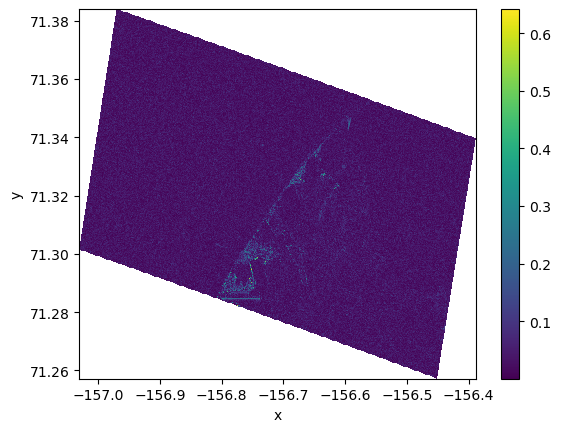

In [99]:
da.plot()

In [100]:
da.rio.to_raster(Path('~/Desktop/test.tif').expanduser())